# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving informaton out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

> 📖 **Resource:** See all course materials, resources and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

Video N° 225: Preparing a notebook for our first NLP with TensorFlow project

## Check for GPU

In [2]:
import numpy as np

from MachineLearningUtils.system_setup.gpu import activate_gpu
activate_gpu()

2024-04-26 15:34:50.360161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 15:34:50.360198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 15:34:50.360745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 15:34:50.365941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPU


2024-04-26 15:34:52.093837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 15:34:52.125252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 15:34:52.125530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
!nvidia-smi -L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
GPU 0: NVIDIA GeForce RTX 3050 (UUID: GPU-ee6cd8ff-34bf-dc58-2edb-4f5120aaec55)


## Get helper functions

In [4]:
from MachineLearningUtils.data_acquisition.data_downloader import *
from MachineLearningUtils.data_visualization.augmentation_effects import *
from MachineLearningUtils.data_visualization.evaluation_metrics import *
from MachineLearningUtils.data_visualization.image_visualization import *
from MachineLearningUtils.data_visualization.model_learning_curves import *
from MachineLearningUtils.data_visualization.prediction_visualization import *
from MachineLearningUtils.training_utilities.model_callbacks import *
from MachineLearningUtils.training_utilities.transfer_learning import *

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [5]:
url = "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
download_data(url=url, file_path="nlp_getting_started.zip", extract=True)

The file nlp_getting_started.zip already exists.
Extracting nlp_getting_started.zip as ZIP...
nlp_getting_started.zip has been extracted to current directory.


Video N°226: Becoming one with the data and visualising a text dataset

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df_shuffled.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) - 5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target= row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
573 deaths have been certified by the Government as Û÷nuclear disaster-related deathsÛª

---

Target: 0 (not real disaster)
Text:
Lee does comedy: ÛÏ@LeeJasper: Working class Tories prepare for your Armageddon. #InterestRateRiseÛ

---

Target: 0 (not real disaster)
Text:
@DrAtomic420 where did you get that pic from where it shows that there is 2 trophies for Outbreak? Or did they photoshop it?

---

Target: 1 (real disaster)
Text:
Watch The Terrifying Moment Two Giant Cranes Collapse Onto Homes: A row of homes was destroyed in seconds. http://t.co/G38Y8H1tJt

---

Target: 1 (real disaster)
Text:
West Nyack Pineview Road railroad crossing off Western Highway. Units on scene of a CSX Train vs. truck no injuries.

---


Video N°227: Splitting data into training and validation sets

### Split data into training and validation sets

We want to be able to see how our model is performing on unseen data whilst it trains.

And because the testing dataset doesn't have labels, we'll have to create a validation dataset to evaluate on (the model won't see the validation dataset during training so we can use its samples and labels to evaluate our model's performance).

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [14]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

Video N°228: Converting text data to numbers using tokenisation and embeddings (overview)
Video N°229: Setting up a TensorFlow TextVectorization layer to convert text to numbers

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [16]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [18]:
train_sentences[0].split(), len(train_sentences[0].split())

(['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'], 7)

In [19]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

Video N°230: Mapping the TextVectorization layer to text data and turning it into numbers

In [21]:
# Fit the text vectorizer instance to the training data using the adapt() method
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
One man fatally shot another wounded on Vermont Street #Buffalo - http://t.co/KakY4mpCO4        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  61,   89, 5667,  616,  165,  269,   11, 3280,  698, 2533,    1,
           0,    0,    0,    0]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Most common words in vocab: {top_5_words}")
print(f"Least common words in vocab: {bottom_5_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
# how long is our vocab?
len(words_in_vocab)

10000

Video N°231: Creating an Embedding layer to turn tokenised text into embedding vectors

## Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer:
[https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
The parameters we care most about for our embedding layer:
- `input_dim` = the size of our vocabulary
- `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
- `input_length` = length of the sequences being passed to the embedding layer

In [26]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set the input shape
                             output_dim=128, # set the size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize embedding vectors randomly
                             input_length=max_length) # how long is each input
embedding

In [27]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}')
print(f'\n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @chillimik @HushLegs haha ??????..Are you really comparing yourselves to the emergency services! Thats brilliant! talk about up your own arse!


Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02990315,  0.04949616,  0.03703756, ...,  0.02563653,
          0.03982755,  0.0421607 ],
        [ 0.02990315,  0.04949616,  0.03703756, ...,  0.02563653,
          0.03982755,  0.0421607 ],
        [ 0.03346178,  0.00355779,  0.02330654, ..., -0.0012197 ,
          0.03560526, -0.01898285],
        ...,
        [ 0.03614289,  0.01712103,  0.02014014, ...,  0.02241273,
          0.01046451,  0.00701421],
        [ 0.02990315,  0.04949616,  0.03703756, ...,  0.02563653,
          0.03982755,  0.0421607 ],
        [-0.01677912,  0.04429232,  0.01013378, ..., -0.02675204,
          0.02928367, -0.03121888]]], dtype=float32)>

In [28]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02990315,  0.04949616,  0.03703756,  0.01163357, -0.04033415,
        -0.02076585, -0.02179154, -0.02338258,  0.01165748,  0.00607039,
         0.03466899, -0.04043154, -0.016248  , -0.01844843,  0.00806891,
         0.04094744,  0.01591679, -0.01962318,  0.0313439 ,  0.01502719,
        -0.0087118 , -0.04644699,  0.01453048, -0.00861041, -0.02607945,
         0.03688386,  0.02285543, -0.00981237, -0.03813227,  0.02189452,
        -0.01080208,  0.02913273,  0.02462106, -0.00733873, -0.03269316,
        -0.00122852,  0.01454045,  0.01925086, -0.01898938, -0.00874591,
         0.02706137,  0.01735474,  0.01629372,  0.00689853, -0.03733911,
         0.01814317,  0.00230678,  0.03635797,  0.02340976,  0.04295314,
        -0.0445341 ,  0.01367049, -0.04998648, -0.01613076,  0.01828435,
        -0.0023437 , -0.0483884 , -0.02910416, -0.02416517, -0.00036416,
         0.00542375, -0.03125447, -0.02475816, -0.03915209, -0.00305201,
  

Video N°232: Discussing the various modelling experiments we're going to run

## Modelling a text dataset (setting up our modelling experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline) - got this from here: [https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor) (using transfer learning for NLP)
* Model 7: Same as model 6 but using 10% of data

How are we going to approach all of these?
Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

Video N°233: Model 0:Building a basline model to try and improve upon

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [29]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    ("clf", MultinomialNB()) # model the text converted to numbers
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

CPU times: user 222 ms, sys: 8.34 ms, total: 230 ms
Wall time: 229 ms


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [32]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

Video N°234: Creating a function to track and evaluate our model's results

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the following metrics:
 
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: [https://scikit-learn.org/stable/modules/model_evaluation.html](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [33]:
# Get baseline results with personal function
baseline_results = evaluate_classification_metrics(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Video N°235: Model1: Building, fitting and evaluating our first deep model on text data

### Model 1: A simple dense model (feed-forward neural network)

In [34]:
# Create tensorboard callback (need to create a new one for each model)
# import personal 'create_tensorboard_callback' function

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [36]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240426-153454
Epoch 1/5


2024-04-26 15:34:55.799349: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdae6604e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 15:34:55.799378: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-04-26 15:34:55.804455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 15:34:55.818332: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1714138495.872048   23075 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 7s 30ms/step - loss: 0.6108 - accuracy: 0.6957 - val_loss: 0.5361 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4411 - accuracy: 0.8205 - val_loss: 0.4707 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3462 - accuracy: 0.8621 - val_loss: 0.4600 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2843 - accuracy: 0.8926 - val_loss: 0.4672 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2369 - accuracy: 0.9121 - val_loss: 0.4795 - val_accuracy: 0.7848


In [39]:
# Evaluate model 1
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4795 - accuracy: 0.7848


[0.4795282781124115, 0.7847769260406494]

In [40]:
# Look at the first 10 predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.36875045],
       [0.8219143 ],
       [0.9980584 ],
       [0.0956081 ],
       [0.11854198],
       [0.9413515 ],
       [0.92507994],
       [0.9938928 ],
       [0.9669489 ],
       [0.22606738]], dtype=float32)

In [41]:
# Convert model prediction
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [42]:
# Caluclate our model_1 results
model_1_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'precision': 0.7900209877855079,
 'recall': 0.7847769028871391,
 'f1': 0.781600538849599}

In [43]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Nous n'avons donc pas de meilleurs résultats avec model_1 comparé à model_0

Video N°236: Visualising our model's learned word embeddings with TensorFlow's projector tool

### Visualizing learned embeddings

To further understand word embeddings, let's visualize them, to do so, we'll get the weights matrix (embedding matrix) from our embedding layer and visualize it using the Embedding project tool, see the TensorFlow guide for more: https://www.tensorflow.org/tutorials/text/word_embeddings

In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
len(words_in_vocab)

10000

In [46]:
max_vocab_length

10000

In [47]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [48]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: [https://projector.tensorflow.org/](https://projector.tensorflow.org/)

And TensorFlow also has an incredible guide on word embeddings themselves: [https://www.tensorflow.org/text/guide/word_embeddings](https://www.tensorflow.org/text/guide/word_embeddings)

In [49]:
# Create embedding files (we got this from TensorFlow's word embedding documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in Colaboratory, you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).
```python
# Download files from Colab to upload projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass
```

Our visual word embeddings might not look like much to us, but they help our model understand the relationships between words.

For more on a popular type of word embedding and more visual explanations check out the illustrated word2vec: [https://jalammar.github.io/illustrated-word2vec/](https://jalammar.github.io/illustrated-word2vec/)

Video N°237: High-level overview of Recurrent Networks (RNNs) + where to learn more

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture [https://www.youtube.com/watch?v=qjrad0V0uJE](https://www.youtube.com/watch?v=qjrad0V0uJE)
- Chris Olah's intro to LSTMs: [https://colah.github.io/posts/2015-08-Understanding-LSTMs/](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: [https://karpathy.github.io/2015/05/21/rnn-effectiveness/](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Video N°238: Model 2: Building, fitting and evaluating our first TensorFlow RNN model (LSTM)

### Model 2:LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/dense) -> Output (label probability)
```

In [50]:
# Create an LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
print(f"input: A 3D tensor with shape [batch, timesteps, feature]")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
#x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences=True
#print(x.shape)

x = layers.LSTM(units=64)(x)
print(f"x: A 2D tensor with shape [batch, features]")
print(f"After LSTM cell: {x.shape}")
#x = layers.Dense(units=64, activation="relu")(x)
#print(f"After Dense layer: {x.shape}")


outputs = layers.Dense(1, activation="sigmoid")(x)#binary data -> sigmoid
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

input: A 3D tensor with shape [batch, timesteps, feature]
After embedding: (None, 15, 128)
x: A 2D tensor with shape [batch, features]
After LSTM cell: (None, 64)


**Resource:** [https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh)

In [51]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [52]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Fit the model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="Model_2_LSTM")])

Saving TensorBoard log files to: model_logs/Model_2_LSTM/20240426-153509
Epoch 1/5
215/215 [==============================] - 9s 34ms/step - loss: 0.2250 - accuracy: 0.9218 - val_loss: 0.5415 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1552 - accuracy: 0.9442 - val_loss: 0.5926 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1289 - accuracy: 0.9511 - val_loss: 0.6166 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1046 - accuracy: 0.9622 - val_loss: 0.9034 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0865 - accuracy: 0.9653 - val_loss: 0.8191 - val_accuracy: 0.7808


In [54]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.1831208e-02],
       [6.7837602e-01],
       [9.9970573e-01],
       [1.2144938e-01],
       [7.0481090e-04],
       [9.9717736e-01],
       [6.7055219e-01],
       [9.9980325e-01],
       [9.9957699e-01],
       [2.9764646e-01]], dtype=float32)

In [55]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [56]:
# Calculate model 2 results
model_2_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 78.08398950131233,
 'precision': 0.7875556029648662,
 'recall': 0.7808398950131233,
 'f1': 0.7770458654848345}

In [57]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [58]:
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Nous n'avons donc pas de meilleurs résultats avec model_2 comparé à model_0

Video N°239: Model 3: Building, fitting and evaluating our first TensorFlow RNN model(LSTM)

### Model 3: GRU

Another popular and effective RNN component is the GRU or 'gated recurrent unit'.

The GRU cell has similar features to an LSTM cell but has less parameters.


In [59]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype=tf.string)
print(f"input: A 3D tensor with shape [batch, timesteps, feature]")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")

x = layers.GRU(units=64)(x)
print(f"After GRU 64 layer: {x.shape}")

#x = layers.GRU(units=64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
#print(f"After GRU 64 layer: {x.shape}")

#x = layers.LSTM(units=64, return_sequences=True)(x)
#print(f"Ater LSTM 64 layer: {x.shape}")

# x = layers.GRU(units=64)(x)
# print(f"After GRU 64 layer: {x.shape}")

#x = layers.Dense(units=64, activation="relu")(x)
#print(f"After Dense 64 layer: {x.shape}")

outputs = layers.Dense(1, activation="sigmoid")(x)
print(f"After Dense 1 layer: {x.shape}")
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

input: A 3D tensor with shape [batch, timesteps, feature]
After embedding: (None, 15, 128)
After GRU 64 layer: (None, 64)
After Dense 1 layer: (None, 64)


In [60]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [61]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
# Fit the model
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240426-153526
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.1566 - accuracy: 0.9384 - val_loss: 0.8301 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0854 - accuracy: 0.9696 - val_loss: 0.9650 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0737 - accuracy: 0.9702 - val_loss: 0.8750 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0631 - accuracy: 0.9753 - val_loss: 0.9861 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0568 - accuracy: 0.9769 - val_loss: 1.0961 - val_accuracy: 0.7769


In [63]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.59176835e-03],
       [6.96748435e-01],
       [9.99796569e-01],
       [1.43050179e-02],
       [1.11947644e-04],
       [9.99483824e-01],
       [5.34092069e-01],
       [9.99938488e-01],
       [9.99861240e-01],
       [6.58692181e-01]], dtype=float32)

In [64]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [65]:
# Calculate model 3 results
model_3_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7805885493126917,
 'recall': 0.7769028871391076,
 'f1': 0.774064384984916}

In [66]:
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Nous n'avons donc pas de meilleurs résultats avec model_3 comparé à model_0

Video N°240: Model 4: Building, fitting and evaluating a bidirectional RNN model

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [67]:
# Building a bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layer=layers.LSTM(units=64, return_sequences=True))(x)
x = layers.Bidirectional(layer=layers.LSTM(units=64))(x)
print(f"64 neurons give 128 parameters because they are bidirectional: {x.shape}")
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

64 neurons give 128 parameters because they are bidirectional: (None, 128)


In [68]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [69]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
# Fit the model
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240426-153543
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.1094 - accuracy: 0.9637 - val_loss: 0.9724 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0539 - accuracy: 0.9769 - val_loss: 1.2284 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0444 - accuracy: 0.9810 - val_loss: 1.3487 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0448 - accuracy: 0.9797 - val_loss: 1.3935 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0392 - accuracy: 0.9809 - val_loss: 1.5234 - val_accuracy: 0.7612


In [71]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(x=val_sentences)
model_4_pred_probs

24/24 [==============================] - 1s 3ms/step


array([[6.71739085e-03],
       [8.18934262e-01],
       [9.99942899e-01],
       [2.27037966e-01],
       [6.25222538e-06],
       [9.98541117e-01],
       [1.96777791e-01],
       [9.99977112e-01],
       [9.99954224e-01],
       [9.96927321e-01],
       [7.13488862e-06],
       [9.88343060e-01],
       [1.01379437e-05],
       [2.96761304e-01],
       [5.64842367e-06],
       [1.25505880e-03],
       [1.09899420e-05],
       [3.81088671e-06],
       [3.47965248e-02],
       [9.99520659e-01],
       [9.11301911e-01],
       [4.33994364e-06],
       [9.99891400e-01],
       [3.24288674e-04],
       [9.99922633e-01],
       [9.99973655e-01],
       [4.46831618e-05],
       [5.83792134e-05],
       [1.21400117e-05],
       [5.85773230e-01],
       [9.51918542e-01],
       [1.85304350e-04],
       [2.34892801e-03],
       [6.74027542e-05],
       [9.94855091e-02],
       [3.29678535e-01],
       [9.99912500e-01],
       [3.49107742e-01],
       [1.03852022e-02],
       [9.99898911e-01],


In [72]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [73]:
# Calculate the results of our bidirectional model
model_4_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'precision': 0.7627664723727715,
 'recall': 0.7611548556430446,
 'f1': 0.7588524417705016}

In [74]:
np.array(list(model_4_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Nous n'avons donc pas de meilleurs résultats avec model_4 comparé à model_0

In [75]:
np.array(list(model_4_results.values())) > np.array(list(model_3_results.values()))

array([False, False, False, False])

Et même moins bien que l'unidirectionnel

Video N°241: Discussing the intuition behind Conv1D neural networks for text and sequences

## Convolutional Neural Networks for text (and other types of sequences)

We've used CNN's for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: 
https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

    "VALID" = without padding:

       inputs:         1  2  3  4  5  6  7  8  9  10 11 (12 13)
                      |________________|                dropped
                                     |_________________|

    "SAME" = with zero padding:

                   pad|                                      |pad
       inputs:      0 |1  2  3  4  5  6  7  8  9  10 11 12 13|0  0
                   |________________|
                                  |_________________|
                                                 |________________|

In this example:

    Input width = 13
    Filter width = 6
    Stride = 5

Notes:

    "VALID" only ever drops the right-most columns (or bottom-most rows).
    "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, it will add the extra column to the right, as is the case in this example (the same logic applies vertically: there may be an extra row of zeros at the bottom).

Edit:

About the name:

    With "SAME" padding, if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs.
    With "VALID" padding, there's no "made-up" padding inputs. The layer only uses valid input data.


In [76]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding 
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="same") # default = 'valid', the output is smaller than the input shape, 'same' means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [77]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01339541,  0.09245402, -0.03264668, ..., -0.08499789,
         -0.01402696,  0.05603618],
        [-0.0651751 , -0.02301826, -0.00299752, ...,  0.03961458,
         -0.00984527,  0.03717094],
        [-0.00684325,  0.0066711 ,  0.03219017, ..., -0.0108359 ,
          0.00675652,  0.01760685],
        ...,
        [-0.01472768, -0.01436972,  0.00787371, ..., -0.01822245,
          0.03257551,  0.01905814],
        [-0.01472768, -0.01436972,  0.00787371, ..., -0.01822245,
          0.03257551,  0.01905814],
        [-0.01472768, -0.01436972,  0.00787371, ..., -0.01822245,
          0.03257551,  0.01905814]]], dtype=float32)>

In [78]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[0.03562415, 0.0345035 , 0.        , 0.00606954, 0.0672408 ,
         0.        , 0.        , 0.        , 0.        , 0.00115975,
         0.02649689, 0.02306382, 0.04108689, 0.        , 0.        ,
         0.01874622, 0.        , 0.03273138, 0.03031998, 0.        ,
         0.        , 0.04599355, 0.        , 0.        , 0.02274476,
         0.        , 0.        , 0.05251557, 0.        , 0.        ,
         0.02282132, 0.00190738],
        [0.02553064, 0.        , 0.04111012, 0.        , 0.        ,
         0.08745392, 0.01252773, 0.02365631, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00115488, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.02432454, 0.01190905, 0.        , 0.        , 0.05855102,
         0.        , 0.04173658, 0.07122966, 0.        , 0.0833336 ,
         0.        , 0.        ],
        [0.08790034, 0.01152979, 0.        , 0.    

In [79]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.08790034, 0.0345035 , 0.06017466, 0.00606954, 0.0672408 ,
        0.08745392, 0.04375487, 0.02365631, 0.04238677, 0.0589821 ,
        0.04934254, 0.07682185, 0.04108689, 0.01994325, 0.        ,
        0.05257731, 0.0252711 , 0.03855599, 0.07254603, 0.        ,
        0.05224176, 0.07069703, 0.05182977, 0.05071816, 0.07507242,
        0.0186191 , 0.0789188 , 0.07122966, 0.05808811, 0.0833336 ,
        0.04074836, 0.05397004]], dtype=float32)>

Video N°242: Model 5: Building, fitting and evaluating a 1D CNN for text

In [80]:
# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(units=64, activation='relu')(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [81]:
# Fit the model
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240426-153603
Epoch 1/5
215/215 [==============================] - 8s 31ms/step - loss: 0.1242 - accuracy: 0.9591 - val_loss: 0.8528 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0743 - accuracy: 0.9721 - val_loss: 1.0921 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0619 - accuracy: 0.9756 - val_loss: 1.1396 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0545 - accuracy: 0.9772 - val_loss: 1.1863 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0516 - accuracy: 0.9783 - val_loss: 1.2783 - val_accuracy: 0.7612


In [82]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(x=val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[3.2872122e-02],
       [9.1617829e-01],
       [9.9986339e-01],
       [4.1924622e-02],
       [8.7987345e-08],
       [9.9365014e-01],
       [9.6694607e-01],
       [9.9995446e-01],
       [9.9999893e-01],
       [9.2062336e-01]], dtype=float32)

In [83]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [84]:
# Calculate results for model 5
model_5_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'precision': 0.7620839190766789,
 'recall': 0.7611548556430446,
 'f1': 0.7592507437677535}

In [85]:
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Nous n'avons donc pas de meilleurs résultats avec model_5 comparé à model_0

Video N°243: Using TensorFlow Hub for pretrained word embeddings (transfer learning for NLP)

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own model's, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder:
- [https://tfhub.dev/google/universal-sentence-encoder/4](https://tfhub.dev/google/universal-sentence-encoder/4)
- [https://www.kaggle.com/models/google/universal-sentence-encoder](https://www.kaggle.com/models/google/universal-sentence-encoder)

See how the USE was created here: [https://arxiv.org/abs/1803.11175](https://arxiv.org/abs/1803.11175)

In [86]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [87]:
embed_samples[0].shape

TensorShape([512])

Video N°244: Model 6: Building, training and evaluating a transfer learning model for NLP

In [88]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [89]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [90]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240426-153627
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5026 - accuracy: 0.7860 - val_loss: 0.4469 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4133 - accuracy: 0.8168 - val_loss: 0.4398 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3993 - accuracy: 0.8219 - val_loss: 0.4301 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3905 - accuracy: 0.8260 - val_loss: 0.4279 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3832 - accuracy: 0.8326 - val_loss: 0.4256 - val_accuracy: 0.8163


In [91]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(x=val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 8ms/step


array([[0.16557246],
       [0.7670332 ],
       [0.9899041 ],
       [0.20263503],
       [0.70506734],
       [0.7804796 ],
       [0.98548317],
       [0.9843183 ],
       [0.95972764],
       [0.10671203]], dtype=float32)

In [92]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [93]:
# Calculate model 6 performance metrics
model_6_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8176377952755906,
 'recall': 0.8162729658792651,
 'f1': 0.8150898751292451}

In [94]:
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

In [95]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Video N°245: Preparing subsets of data for model 7 (same as model 6 but 10% of data)
Modified during N°247

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data

In [96]:
# ## Noote: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT make data splits which leak data from validation/test sets into training set

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [97]:
# Making a better dataset split (no data leakage)
number_of_rows = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:number_of_rows]
train_labels_10_percent = train_labels[:number_of_rows]

In [98]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [99]:
_# Check the number of targets in our subset of data
# train_10_percent["target"].value_counts()

4576

In [100]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Video N°246: Model 7: Building, training and evaluating a transfer learning model on 10% data

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: [https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model)

In [101]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
# Problème: le nom du modèle reste "model_6_USE, pour éviter des erreurs d'interprétations nous recréons model_7:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name="model_7_USE")
# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [102]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20240426-153644
Epoch 1/5
22/22 [==============================] - 2s 39ms/step - loss: 0.6722 - accuracy: 0.6628 - val_loss: 0.6479 - val_accuracy: 0.7270
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5980 - accuracy: 0.8000 - val_loss: 0.5869 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5229 - accuracy: 0.8161 - val_loss: 0.5346 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4610 - accuracy: 0.8234 - val_loss: 0.5035 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4213 - accuracy: 0.8336 - val_loss: 0.4877 - val_accuracy: 0.7717


In [103]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(x=val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 9ms/step


array([[0.19754905],
       [0.55347306],
       [0.9157675 ],
       [0.34661958],
       [0.5384966 ],
       [0.72615373],
       [0.8908494 ],
       [0.8353292 ],
       [0.8721586 ],
       [0.19200839]], dtype=float32)

In [104]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [105]:
# Evaluating model 7 predictions
model_7_results = evaluate_classification_metrics(y_true=val_labels,
                                                  y_pred=model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'precision': 0.7717840407633899,
 'recall': 0.7716535433070866,
 'f1': 0.7705026760144871}

In [106]:
np.array(list(model_7_results.values())) > np.array(list(model_6_results.values()))

array([False, False, False, False])

Video N°247: Fixing our data leakage issue with model 7 and retraining it
Video N°248: Comparing all our modelling experiments evaluation metrics

## Comparing the performance of each of our models

In [107]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [108]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.784777,0.790021,0.784777,0.781601
2_lstm,0.780840,0.787556,0.780840,0.777046
3_gru,0.776903,0.780589,0.776903,0.774064
4_bidirectional,0.761155,0.762766,0.761155,0.758852
5_conv1d,0.761155,0.762084,0.761155,0.759251
6_tf_hub_use_encoder,0.816273,0.817638,0.816273,0.815090
7_tf_hub_use_encoder_10_percent,0.771654,0.771784,0.771654,0.770503


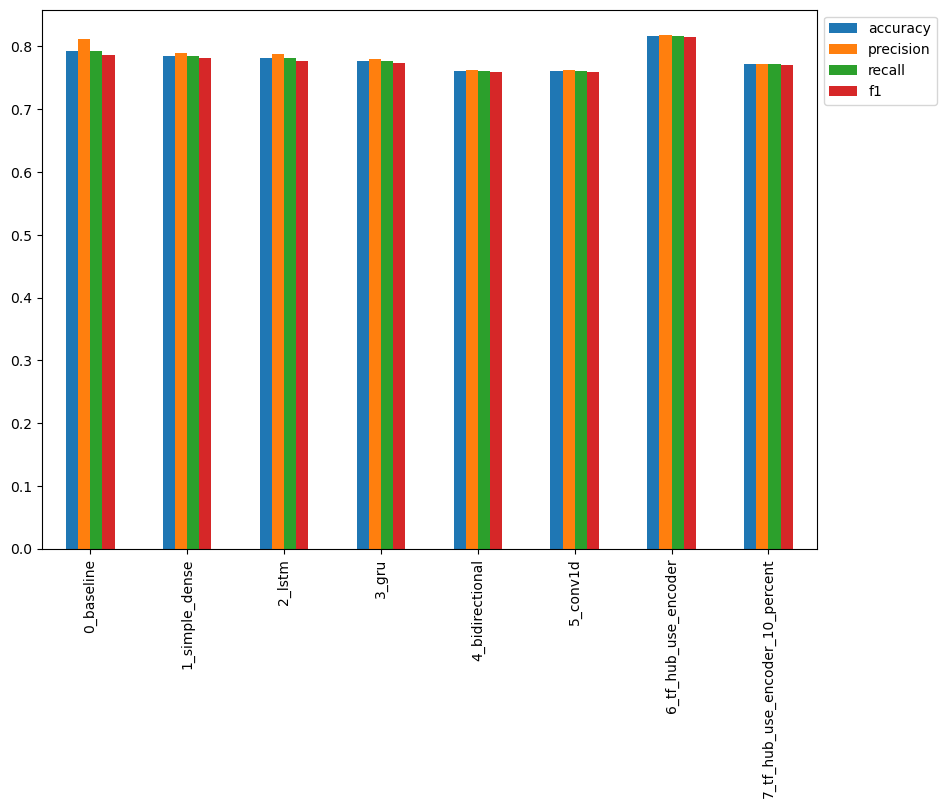

In [109]:
# Plot and compare all the model results
all_model_results.plot(kind="bar",
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

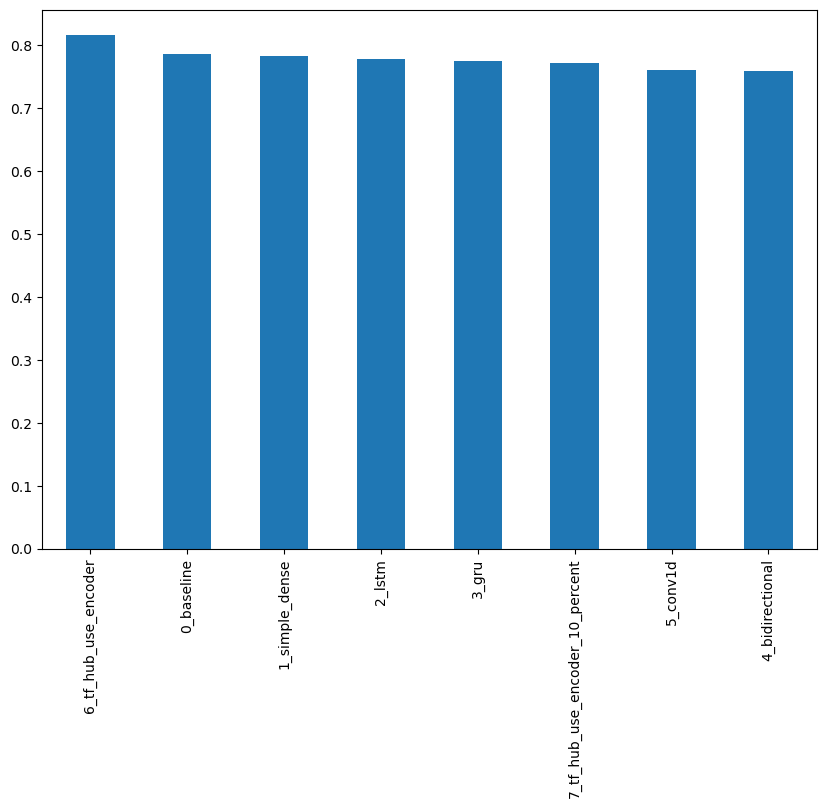

In [110]:
# Sort model results by f1-score
all_model_results.sort_values(by="f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

Video N°249: Uploading our model's training logs to TensorBoard and comparing them

## Uploading our model training logs to TensorBoard.dev
Personal note: I use TensorBoard locally to visualize

In [111]:
# As this command runs indefinitely, it is better to run it from the shell prompt
#!tensorboard --logdir=./model_logs/

**Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: [https://wandb.ai/site](https://wandb.ai/site)

Video N°250: Saving and loading in a trained NLP model with TensorFlow

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [113]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/home/wm18vw/Documents/EnvironnementsDevPython/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                          custom_objects={"KerasLayer": hub.KerasLayer})

In [116]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4256 - accuracy: 0.8163


[0.4255692660808563, 0.8162729740142822]

Now let's save to the `SavedModel` format...

In [117]:
# Save TF Hub Sentence Encoder model to SavedModel formar (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [118]:
# Load in a model from the SaveModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [119]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4256 - accuracy: 0.8163


[0.4255692660808563, 0.8162729740142822]

Video N°251: Downloading a pretrained model and preparing data to investigate predictions

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [120]:
# Download a pretrained model from Google Storage
url = "https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip"
download_data(url=url, file_path="08_model_6_USE_feature_extractor.zip", extract=True)

--2024-04-26 17:21:51--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.23.219, 172.217.168.219, 172.217.168.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.23.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: '08_model_6_USE_feature_extractor.zip'

     0K .......... .......... .......... .......... ..........  0%  434K 36m3s
    50K .......... .......... .......... .......... ..........  0%  420K 36m38s
   100K .......... .......... .......... .......... ..........  0%  801K 30m56s
   150K .......... .......... .......... .......... ..........  0% 1.29M 26m9s
   200K .......... .......... .......... .......... ..........  0% 1.46M 23m1s
   250K .......... .......... .......... .......... ..........  0% 1.07M 21m33s
   300K .......... .......... .......... .......... ..........  

08_model_6_USE_feature_extractor.zip has been downloaded.
Extracting 08_model_6_USE_feature_extractor.zip as ZIP...
08_model_6_USE_feature_extractor.zip has been extracted to current directory.


In [122]:
# Import previously trained model from Google Storage
with tf.device('/cpu:0'):
    model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
    model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4272 - accuracy: 0.8163


In [124]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds

24/24 [==============================] - 0s 9ms/step


<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [127]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [128]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values(by="pred_prob", ascending=False)
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [141]:
# Le code du cours n'est pas correct, j'adapte en conséquence
most_wrong_false_negatives = most_wrong[most_wrong["pred"] == 0]
most_wrong_false_positives = most_wrong[most_wrong["pred"] == 1]

In [143]:
most_wrong_false_positives # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [144]:
most_wrong_false_negatives # these are false negatives

,text,target,pred,pred_prob
541,@Dirk_NoMissSki yea but if someone faints why ...,1,0.0,0.497857
69,Back from Seattle Tacoma and Portland. Whirlwi...,1,0.0,0.495021
335,#computers #gadgets Two giant cranes holding a...,1,0.0,0.492785
659,I moved to England five years ago today. What ...,1,0.0,0.492553
475,China's Stock Market Crash: Are There Gems In ...,1,0.0,0.491344
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

Video N°252: Visualising our model's most wrong predictions

In [145]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong_false_positives[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [146]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong_false_negatives[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0.0, Prob: 0.49785667657852173
Text:
@Dirk_NoMissSki yea but if someone faints why are they panicking?.. thats basic stuff ??

----

Target: 1, Pred: 0.0, Prob: 0.4950205385684967
Text:
Back from Seattle Tacoma and Portland. Whirlwind! http://t.co/qwHINBni8e

----

Target: 1, Pred: 0.0, Prob: 0.4927854537963867
Text:
#computers #gadgets Two giant cranes holding a bridge collapse into nearby homes http://t.co/UZIWgZRynY #slingnews

----

Target: 1, Pred: 0.0, Prob: 0.49255257844924927
Text:
I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7

----

Target: 1, Pred: 0.0, Prob: 0.49134400486946106
Text:
China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/BqBLWiw08g #ROIMentor #yycwalks

----

Target: 1, Pred: 0.0, Prob: 0.4635712802410126
Text:
Medieval airplane hijacker testa: earnings the distinction divers: HtaRvrGLY

----

Target: 1, Pred: 0.0, Prob: 0.4567418694496155
Text:
DireTube Information ÛÒ E

Video N°253: Making and visualising predictions on the test dataset

## Making the predictions on the test dataset

In [149]:
# Making predictions on the test dataset and visualising them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("-----\n")

1/1 [==============================] - 0s 43ms/step
Pred: 1, Prob: 0.7112652063369751
Text:
Investigators rule catastrophic structural failure resulted in 2014 Virgin Galactic crash http://t.co/nLzbHcfXCM

-----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.30625802278518677
Text:
@PopMech ANOTHER tweet double posted within 4 hrs. Flooding my timeline with the duplicate tweets.

-----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.07129381597042084
Text:
11000 SEEDS 30 VEGETABLE FRUIT VARIETY GARDEN KIT EMERGENCY SURVIVAL GEAR MRE  - Full reaÛ_ http://t.co/VE78djgHa5 http://t.co/ugubwRPQFP

-----

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.47226718068122864
Text:
@PauloSergioMDC @TheIranDeal @POTUS Those silly talks trusting a terrorist nation (who hates us) that has vowed to obliterate Israel.

-----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.08442673832178116
Text:
I had trouble breat

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.
Then pass that Tweet through our trained model.
Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

Video N°254: Understanding the concept of the speed/score tradeoff

## The speed/score tradeoff

In [150]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples) # make predictions
  end_time = time.perf_counter()
  total_time = end_time-start_time # calculuate how long predictons took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [151]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained, samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3356609149996075, 0.00044049988845092845)

In [152]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0, samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.022217532998183742, 2.9156867451684702e-05)

In [153]:
# Get results for pretrained GS model
model_6_pretrained_results = evaluate_classification_metrics(y_true=val_labels,
                                                             y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

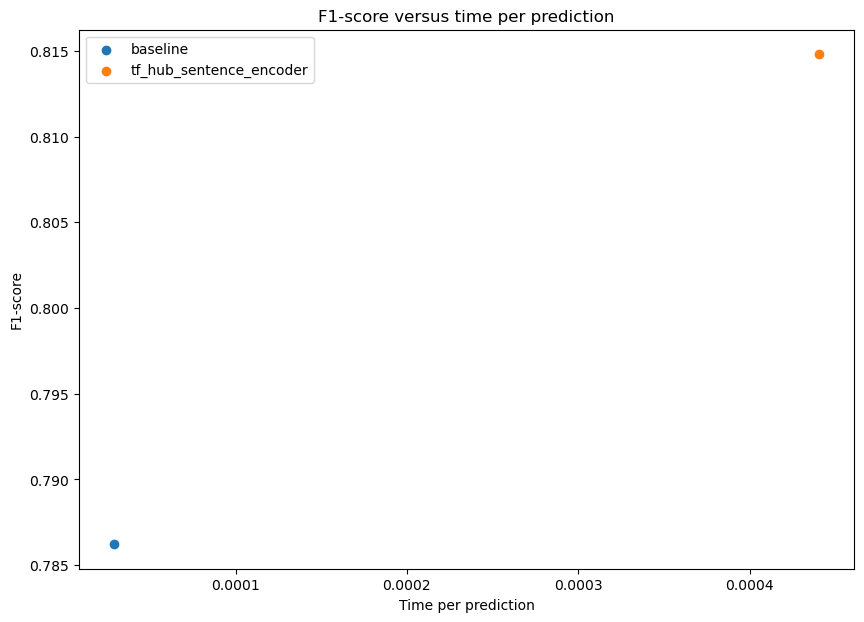

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")